In [1]:
# Library setup
%reset -f
%matplotlib inline
import os
os.environ['R_HOME'] = "/Library/Frameworks/R.framework/Versions/4.0/Resources"
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from lifelines.utils import concordance_index as c_index_score
from lights.inference import prox_QNEM
from lights.base.utils import visualize_vect_learning, plot_history
import numpy as np
from sklearn.preprocessing import StandardScaler
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable
from matplotlib import rc
rc('text', usetex=True)
%matplotlib inline

def printmd(string):
    display(Markdown(string))
import rpy2.robjects as robjects

from time import time

import warnings
%load_ext rpy2.ipython

2 PBC dataset
=============

This dataset is a follow-up to the original dataset from the Mayo Clinic
trial in primary biliary cirrhosis (PBC) of the liver conducted between
1974 and 1984. A total of 424 PBC patients, referred to Mayo Clinic
during that ten-year interval, met eligibility criteria for the
randomized placebo controlled trial of the drug D-penicillamine. The
first 312 cases in the data set participated in the randomized trial and
contain largely complete data. The additional 112 cases did not
participate in the clinical trial, but consented to have basic
measurements recorded and to be followed for survival. Six of those
cases were lost to follow-up shortly after diagnosis, so the data here
are on an additional 106 cases as well as the 312 randomized
participants. The dataset contains only baseline measurements of the
laboratory paramters and contains multiple laboratory results, but only
on the first 312 patients. The data are in open-access in *JMbayes*
package.

2.3 Selection of training and test datasets
-------------------------------------------

To illustrate the competing models, 4/5 of the subjects (n=250) were
randomly selected to form the training data for fitting joint models,
and the remaining 1/5 (n=62) were used to form the test data for
evaluation of prediction.

In [2]:
robjects.r('data(pbc2, package = "JMbayes")')
robjects.r('data <- pbc2')
robjects.r('colnames <- names(pbc2)')
robjects.r('data$T_long <- data$year')
robjects.r('data$T_survival <- data$years')
robjects.r('data$delta <- data$status2')
robjects.r('data$SGOT <- log(data$SGOT)')
robjects.r('data$serBilir <- log(data$serBilir)')
robjects.r('data$albumin <- log(data$albumin)')

# Select training and test samples
robjects.r('data$id <- as.numeric(data$id)')
robjects.r('set.seed(2020)')
robjects.r('lenght_id <- length(unique(data$id))')
robjects.r('id_test <- sample(unique(data$id), round(lenght_id/5))')

# training dataset
robjects.r('data_train <- data[which(!(data$id %in% id_test)), ]')
robjects.r('data_train.id <- unique(data_train[, c("id", "T_survival", "delta", "drug", "sex", "age")])')

# testing dataset
robjects.r('t_max <- 4')
robjects.r('data_test <- data[which(data$id %in% id_test), ]')
robjects.r('data_test.id <- unique(data_test[, c("id", "T_survival", "delta", "drug", "sex", "age")])')
robjects.r('time_dep_feat = list("serBilir", "SGOT", "albumin")')
robjects.r('time_indep_feat = list("age", "drug", "sex")')

[no name],[RTYPES.STRSXP]
[no name],[RTYPES.STRSXP]
[no name],[RTYPES.STRSXP]


3 Lights
=======

In [3]:
# dataset setup
colnames_pbc2 = robjects.globalenv['colnames']
data_training = robjects.globalenv['data_train']
data_training = pd.DataFrame(data_training, index = data_training.colnames).T
data_testing = robjects.globalenv['data_test']
data_testing = pd.DataFrame(data_testing, index = data_testing.colnames).T
n_training_samples = data_training["id"].drop_duplicates().shape[0]
n_testing_samples = data_testing["id"].drop_duplicates().shape[0]
time_dep_feat = ["serBilir", "SGOT", "albumin"]
time_indep_feat = ["age", "drug", "sex"]
n_long_features = len(time_dep_feat)

In [4]:
# data preprocessing
# survival training data
survival_data_training = data_training[["id", "T_survival", "delta"] + time_indep_feat].drop_duplicates()
X_train = survival_data_training[time_indep_feat]
labelencoder = LabelEncoder()
X_train["drug"] = labelencoder.fit_transform(X_train["drug"])
X_train["sex"] = labelencoder.fit_transform(X_train["sex"])
X_train = X_train.values
X_train[:,1] = StandardScaler().fit_transform(X_train[:,1].reshape(-1, 1)).flatten()
T_train = survival_data_training[["T_survival"]].values.flatten()
delta_train = survival_data_training[["delta"]].values.flatten()

# longitunal training data
Y_train_ = data_training[["id", "T_long"] + time_dep_feat]
Y_train_[time_dep_feat] = StandardScaler().fit_transform(Y_train_[time_dep_feat])
Y_train = pd.DataFrame(columns=time_dep_feat)
id_list = np.unique(Y_train_["id"])
Y_tsfresh_train = pd.DataFrame(columns=["id", "time", "kind", "value"])
for i in range(n_training_samples):
    y_i = []
    for l in range(n_long_features):
        Y_il = Y_train_[["T_long", time_dep_feat[l]]][Y_train_["id"]==id_list[i]]
        # TODO: Add value of 1/365 (the first day of survey instead of 0)
        y_il = Y_il[time_dep_feat[l]].values
        t_il = Y_il["T_long"].values + 1/365
        n_il = len(t_il)
        y_i += [pd.Series(y_il, index=t_il)]
        tmp = {"id": [i] * n_il,
              "time": t_il,
              "kind": ["long_feat_" + str(l)] * n_il,
              "value": y_il}
        Y_tsfresh_train = Y_tsfresh_train.append(pd.DataFrame(tmp), ignore_index=True)
    Y_train.loc[i] = y_i
    
# survival testing data
survival_data_testing = data_testing[["id", "T_survival", "delta"]  + time_indep_feat].drop_duplicates()
X_test = survival_data_testing[time_indep_feat]
labelencoder = LabelEncoder()
X_test["drug"] = labelencoder.fit_transform(X_test["drug"])
X_test["sex"] = labelencoder.fit_transform(X_test["sex"])
X_test = X_test.values
X_test[:,1] = StandardScaler().fit_transform(X_test[:,1].reshape(-1, 1)).flatten()
T_test = survival_data_testing[["T_survival"]].values.flatten()
delta_test = survival_data_testing[["delta"]].values.flatten()

# longitunal testing data 
Y_test_ = data_testing[["id", "T_long"] + time_dep_feat]
Y_test_[time_dep_feat] = StandardScaler().fit_transform(Y_test_[time_dep_feat])
Y_test = pd.DataFrame(columns=time_dep_feat)
id_list = np.unique(Y_test_["id"])
Y_tsfresh_test = pd.DataFrame(columns=["id", "time", "kind", "value"])
for i in range(n_testing_samples):
    y_i = []
    for l in range(n_long_features):
        Y_il = Y_test_[["T_long", time_dep_feat[l]]][Y_test_["id"]==id_list[i]]
        y_il = Y_il[time_dep_feat[l]].values
        t_il = Y_il["T_long"].values + 1/365
        n_il = len(t_il)
        y_i += [pd.Series(y_il, index=t_il)]
        tmp = {"id": [i] * n_il,
              "time": t_il,
              "kind": ["long_feat_" + str(l)] * n_il,
              "value": y_il}
        Y_tsfresh_test = Y_tsfresh_test.append(pd.DataFrame(tmp), ignore_index=True)
    Y_test.loc[i] = y_i

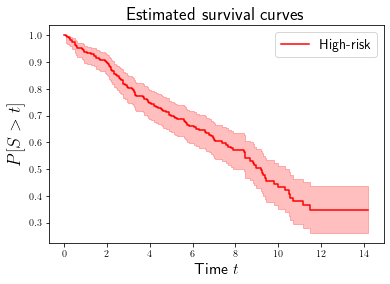

In [5]:
fontsize = 16
# Kaplan Meier estimation of survival curves
kmf = KaplanMeierFitter()
kmf.fit(T_train, delta_train, label="High-risk").plot(c='r')
plt.legend(fontsize=fontsize-2)
plt.xlabel('Time $t$', size=fontsize)
plt.ylabel(r'$P[S > t]$', size=fontsize+2)
plt.title("Estimated survival curves", size=fontsize+2)
plt.show()

### Visualize longitudinal processes for a randomly chosen

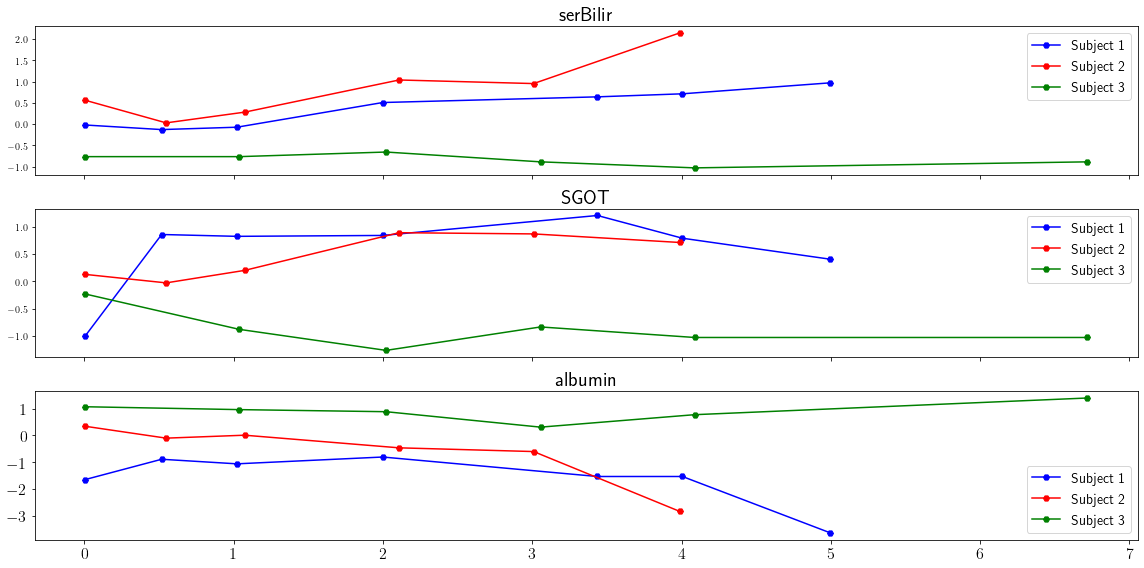

In [6]:
np.random.seed(10)
fig, ax = plt.subplots(n_long_features, 1, sharex=True, figsize=(16,8))
colors, labels = ['b', 'r', 'g'], ['Subject 1', 'Subject 2', 'Subject 3']
idx_list = [2, 3, 4]
for k in [0, 1, 2]:
    idx = idx_list[k]
    Y_i = Y_train.loc[idx, :]
    label, color = labels[k], colors[k]
    for l in range(n_long_features):
        Y_il = Y_i[time_dep_feat[l]]
        Y_il.plot(label=label, color=color, marker='H', ax=ax[l])
        ax[l].set_title(time_dep_feat[l], fontsize=fontsize+4)
        plt.xticks(fontsize=fontsize), plt.yticks(fontsize=fontsize)
        ax[l].legend(fontsize=fontsize-2)
fig.tight_layout()
plt.show()

Launching the solver prox_QNEM...


Feature Extraction: 100%|██████████| 20/20 [00:00<00:00, 29.93it/s]


Feature Extraction: 100%|██████████| 20/20 [00:00<00:00, 39.76it/s]


Feature Extraction: 100%|██████████| 20/20 [00:00<00:00, 31.74it/s]


Launching the solver MLMM...
Launching the solver ULMM...


/Users/acsi/Working/lights_experiments/.test_env_exp/lib/python3.6/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


Done solving using ULMM in 2.76e+00 seconds
 n_iter  |   obj    | rel_obj 
       0 |   4867.3 |      inf
       1 |  4396.61 | 9.67e-02
       2 |  4308.81 | 2.00e-02
       3 |  4264.45 | 1.03e-02
       4 |  4239.84 | 5.77e-03
       5 |  4225.17 | 3.46e-03
       6 |   4215.8 | 2.22e-03
       7 |  4209.42 | 1.51e-03
       8 |  4204.84 | 1.09e-03
       9 |  4201.43 | 8.11e-04
      10 |  4198.81 | 6.23e-04
Done solving using MLMM in 4.30e+00 seconds
 n_iter  |   obj    | rel_obj 
       0 |  27.0824 |      inf
       1 |  24.6795 | 8.87e-02
       2 |  23.0385 | 6.65e-02
       3 |  21.5976 | 6.25e-02
       4 |   21.096 | 2.32e-02
       5 |  20.8205 | 1.31e-02
       6 |   20.621 | 9.58e-03
       7 |  20.4572 | 7.94e-03
       8 |  20.3139 | 7.00e-03
       9 |  20.1835 | 6.42e-03
      10 |  20.0633 | 5.95e-03
Done solving using prox_QNEM in 2.26e+02 seconds


Feature Extraction: 100%|██████████| 19/19 [00:00<00:00, 148.74it/s]


Feature Extraction: 100%|██████████| 19/19 [00:00<00:00, 229.37it/s]


Feature Extraction: 100%|██████████| 19/19 [00:00<00:00, 231.21it/s]


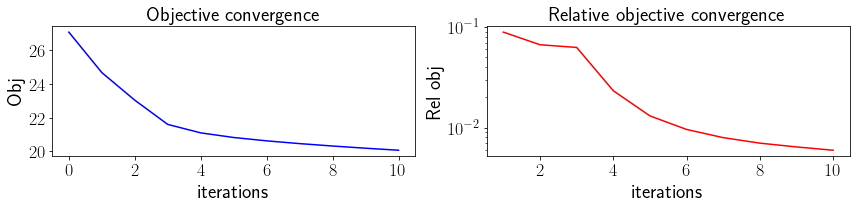

In [7]:
## Choose parameters ##
tol = 1e-6            # tolerance for the convergence stopping criterion 
eta = 0.3             # parameter controlling the trade-off between l1 
                      # and l2 regularization in the elasticNet
gamma_chosen = '1se'  # way to select l_elasticNet_chosen: '1se' or 'min'
warm_start = True     # at each L-BGFS-B iteration, reset beta to 0 or take 
                      # the previous value 
grid_size = 30        # grid size for the cross validation procedure
metric = 'C-index'    # cross-validation metric: 'log_lik' or 'C-index'
fc_parameters = {
    "mean": None,
    "median": None,
    "quantile": [{"q": 0.25}, {"q": 0.75}]
}

start = time()
# declare learner here
fixed_effect_time_order = 1
learner = prox_QNEM(fixed_effect_time_order=fixed_effect_time_order,
                max_iter=10, initialize=True, print_every=1, simu=False,
                      l_pen_SGL=0.02, eta_sp_gp_l1=.9, l_pen_EN=0.02, fc_parameters=fc_parameters)
learner.fit(X_train, Y_train, T_train, delta_train, Y_tsfresh_train)

lights_c_index = learner.score(X_test, Y_test, T_test, delta_test, Y_tsfresh_test)
lights_exe_time = time() - start

# Visualize learning
visualize_vect_learning(learner, "obj")

In [8]:
def visualize_vect_learning_pbc(learner, name, symbol = None,
                            legend_est = None, legend_true = None):
    """Plots learning for a given parameter vector : objective and relative
    objective function, as well as evolution of estimators through iterations

    Parameters
    ----------
    learner : `ligths.base.base.Learner`
        A base learner

    name : `str`
        Name of the element to be plotted

    symbol : `str`
        Symbol of the element to be plotted

    legend_est : `list`
        Names of each estimator coefficients

    legend_true : `list`
        Names of each true parameter coefficients
    """
    fs = 18
    fig = plt.figure(figsize=(8, 4))
    ax = fig.add_subplot(111)
    plt.title("%s learning" % symbol, fontsize=fs + 2)
    plt.xlabel('iterations', fontsize=fs + 2)
    plt.xticks(fontsize=fs), plt.yticks(fontsize=fs)
    cm = 'Dark2'
    plot_history(learner, name=name, ax=ax, colormap=cm, alpha=.8)

    legend1 = ax.legend(legend_est, loc='center right',
                        bbox_to_anchor=(-0.1, 0.5), fontsize=fs)
    plt.gca().add_artist(legend1)

    fig.tight_layout()
    plt.show()

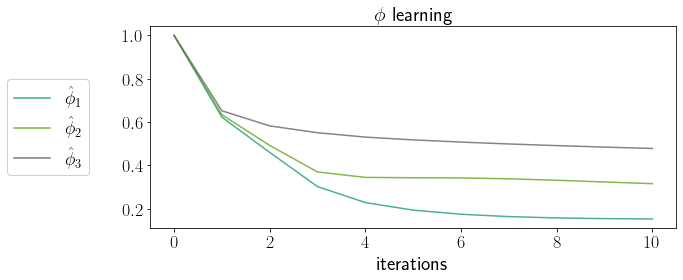

In [9]:
# Visualize phi
to = len(learner.theta["phi"])+1
leg1 = [r"$\hat \phi_%s$" % j for j in range(1, to)]
leg2 = [r"$\phi_%s$" % j for j in range(1, to)]
visualize_vect_learning_pbc(learner, "phi", symbol = r"$\phi$", legend_est = leg1, legend_true = leg2)

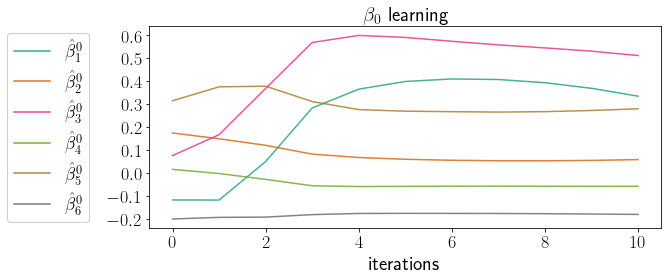

In [10]:
# Visualize beta_0
to = len(learner.theta["beta_0"])+1
leg1 = [r"$\hat \beta^0_%s$" % j for j in range(1, to)]
leg2 = [r"$\beta^0_%s$" % j for j in range(1, to)]
visualize_vect_learning_pbc(learner, "beta_0", r"$\beta_0$", leg1, leg2)

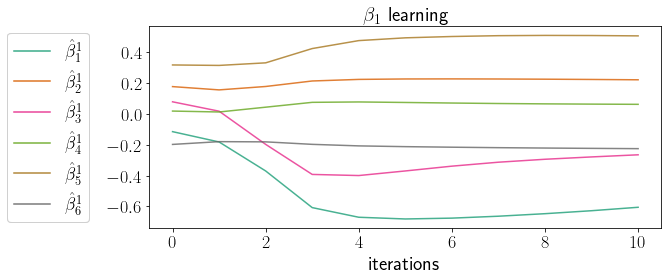

In [11]:
# Visualize beta_1
to = len(learner.theta["beta_1"])+1
leg1 = [r"$\hat \beta^1_%s$" % j for j in range(1, to)]
leg2 = [r"$\beta^1_%s$" % j for j in range(1, to)]
visualize_vect_learning_pbc(learner, "beta_1", r"$\beta_1$", leg1, leg2)

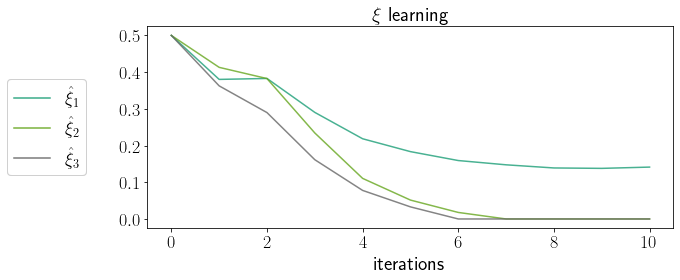

In [12]:
# Visualize xi
to = len(learner.theta["xi"])+1
leg1 = [r"$\hat \xi_%s$" % j for j in range(1, to)]
leg2 = [r"$\xi_%s$" % j for j in range(1, to)]
visualize_vect_learning_pbc(learner, "xi", r"$\xi$", leg1, leg2)

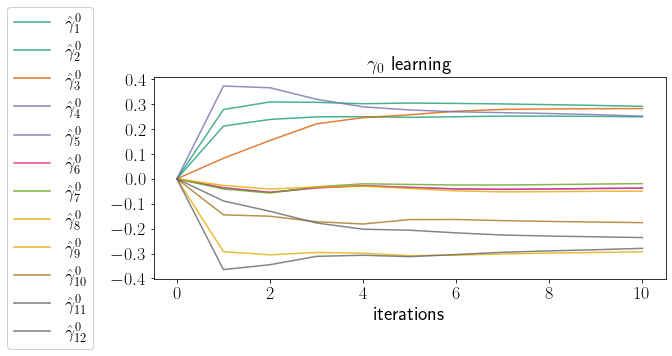

In [13]:
# Visualize gamma_0
to = len(learner.theta["gamma_0"])+1
leg1 = [r"$\hat \gamma^0_{%s}$" % j for j in range(1, to)]
leg2 = [r"$\gamma^0_{%s}$" % j for j in range(1, to)]
visualize_vect_learning_pbc(learner, "gamma_0", r"$\gamma_0$", leg1, leg2)

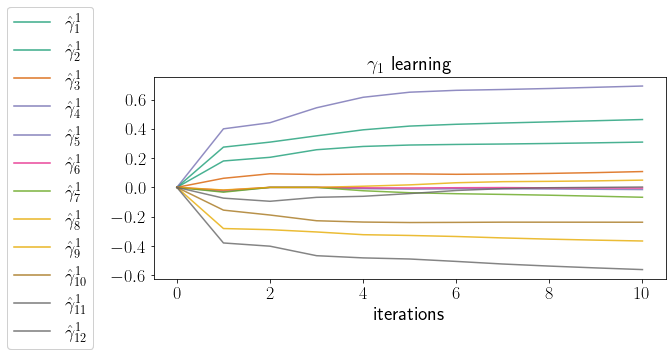

In [14]:
# Visualize gamma_0
to = len(learner.theta["gamma_1"])+1
leg1 = [r"$\hat \gamma^1_{%s}$" % j for j in range(1, to)]
leg2 = [r"$\gamma^1_{%s}$" % j for j in range(1, to)]
visualize_vect_learning_pbc(learner, "gamma_1", r"$\gamma_1$", leg1, leg2)

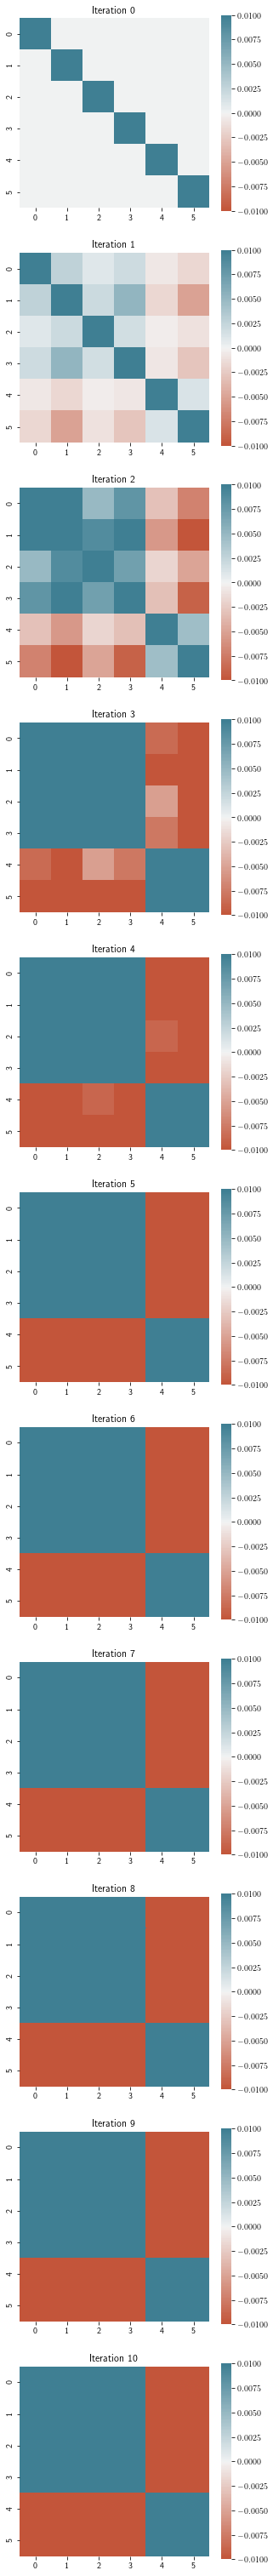

In [15]:
long_cov_history = learner.history.values["long_cov"]
fig, axes = plt.subplots(len(long_cov_history), 1, figsize=(5, 5 * len(long_cov_history)), sharey=True)
for i in range(len(long_cov_history)):
    sns.heatmap(
    data=long_cov_history[i], 
    vmin=-.01, vmax=.01, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True, ax=axes[i]
    )
    axes[i].set_title("Iteration {}".format(i))

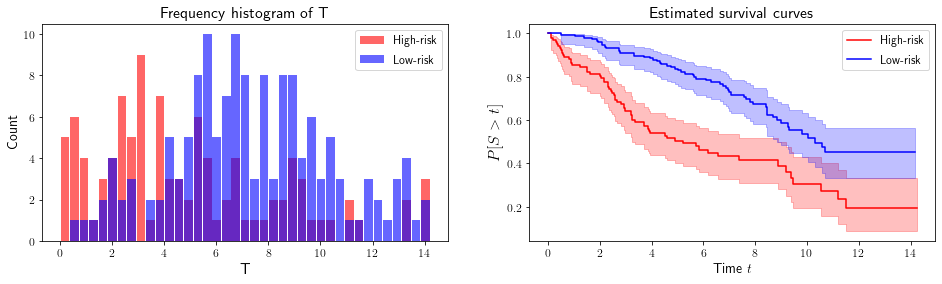

In [16]:
fig = plt.figure(figsize=(16, 4))
fontsize = 14
ax = fig.add_subplot(1,2,1)
bins = np.linspace(0, T_train.max(), 40)
kwargs = dict(bins=bins, alpha=0.6, rwidth=0.9)
plt.hist(T_train[learner.pi_est < .5], **kwargs, color='r', label='High-risk')
plt.hist(T_train[learner.pi_est > .5], **kwargs, color='b', label='Low-risk')
plt.legend(fontsize=fontsize-2)
plt.xlabel("T", size=fontsize+2)
plt.ylabel("Count", size=fontsize)
ax.tick_params(labelsize=fontsize-2)
plt.title("Frequency histogram of T", size=fontsize+2)

# Kaplan Meier estimation of survival curves
kmf = KaplanMeierFitter()
ax = plt.subplot(122)
kmf.fit(T_train[learner.pi_est < .5], delta_train[learner.pi_est < .5], label="High-risk").plot(ax=ax, c='r')
kmf.fit(T_train[learner.pi_est > .5], delta_train[learner.pi_est > .5], label="Low-risk").plot(ax=ax, c='b')
plt.legend(fontsize=fontsize-2)
plt.xlabel('Time $t$', size=fontsize)
plt.ylabel(r'$P[S > t]$', size=fontsize+2)
plt.title("Estimated survival curves", size=fontsize+2)
ax.tick_params(labelsize=fontsize-2)
plt.show()